# Logit, Tree, RF, and LGBM
1. Logistic Regression
2. Decision Tree Classifier
3. Random Forest Classifier
4. Light Gradient Boosting Method

# 1 Basic Procedures
## 1.1 Importing necessary packages

In [1]:
# Based on kernel provided by Kaggle
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import warnings
import pprint

# Data processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Style
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn visualization library
sns.set(style="darkgrid")

# File System
import os
print(os.listdir("../input"))

# Memory management
import gc # Garbage Collector
%matplotlib inline
# %matplotlib inline is a kind of magic fucntion
# it sets up the integration so you can create multiple plot windows without interfering with the console session;
# no need to use plt.show() anymore;

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


## 1.2 Import Dataset

### 1.2.1 Read CSV

In [2]:
# Read CSV
%time train = pd.read_csv('../input/train.csv')
%time test = pd.read_csv('../input/test.csv')

Wall time: 15.8 s
Wall time: 17.3 s


### 1.2.2 How is the data like?

In [3]:
# Look at first 5 records of the train dataset
train.head(3)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965


In [4]:
# Check out the shape of the train and test sets
print('Train shape:', train.shape,'\n')
print('Test  shape:', test.shape,'\n')

# Check the target values
print('Target variable:')
train['target'].value_counts()

Train shape: (200000, 202) 

Test  shape: (200000, 201) 

Target variable:


0    179902
1     20098
Name: target, dtype: int64

## 1.3 Import models

In [5]:
#from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score # , KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

## 1.4 Process data
### Split X and Y

In [6]:
# Target variable from the training set
Target = train['target']

# Input dataset for training and testing
train_inp = train.drop(columns = ['target', 'ID_code'])
test_inp  = test.drop(columns = ['ID_code'])

# List of feature names
features = list(train_inp.columns)

### Split data into training set and test set

In [7]:
# Split the data into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(train_inp, Target, test_size= 0.3, random_state = 2019)
print('Raw Y_test:')
print(Y_test.value_counts(),'\n')

# check the shapes of training set and test set
print('Shape of Train Set:', X_train.shape)
print('Shape of Test Set:', X_test.shape)

Raw Y_test:
0    53951
1     6049
Name: target, dtype: int64 

Shape of Train Set: (140000, 200)
Shape of Test Set: (60000, 200)


### Prepare 5050 data (discarded)

In [29]:
# Make test set 50:50
#Y_test5050 = pd.concat([Y_test[Y_test == 1], Y_test[Y_test == 0][:Y_test.sum()]])
#X_test5050 = X_test.reindex(Y_test5050.index)
#print('\nProcessed Y_test:\n', Y_test5050.value_counts())
#print('\nShape of X_test:\n', X_test5050.shape)
#print('\nHead of X_test:\n', X_test5050.head(3))
#print('\nHead of Y_test\n', Y_test5050.head(3))

# make training set 5050
Y_train5050 = pd.concat([Y_train[Y_train == 1], Y_train[Y_train == 0][:Y_train.sum()]])
X_train5050 = X_train.reindex(Y_train5050.index)
#print('\nProcessed Y_test:\n', Y_train5050.value_counts())
#print('\nShape of X_train:\n', X_train5050.shape)
#print('\nHead of X_test:\n',X_train5050.head(3))
#print('\nHead of Y_test:\n',Y_train5050.head(3))

## 1.5 General Functions

In [23]:
# Performance function
def performance(Y_test, Y_pred):
    
    Y_pred_int = [0 if i < 0.5 else 1 for i in Y_pred]
    
    # Confusion matrix
    print('\nConfusion Matrix:')
    print(confusion_matrix(Y_test, Y_pred_int)) 
    
    # Classification report
    print('\nClassification Report:')
    print(classification_report(Y_test, Y_pred_int))
    
    # AUC
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred, pos_label=1)
    print('AUC:')
    print(auc(fpr, tpr))

# 2 Logistic Regression
Logistic Regression is the most basic algorithm used for classification problems.
* Future improvements:
    * other solver (except lbfgs, liblinear), along with other penalty (l1)
    * **Tuning the hyper-parameters**
    * **ensemble learning methods**
    * **cross validation** (Docu-sklearn P438: *sklearn.linear_model.LogisticRegressionCV*)
* Problems:
    * do I need to change the loss function?
* Other things about logistic regression:
    * If not specifying a solver, there will be "FutureWarning: Default solver will be changed to 'lbfgs' in 0.22."

## 2.1 Logit in default
* Reference: Sklearn-Documentation P1798 *sklearn.linear_model.LogisticRegression*
    * in default in v0.20, penalty = 'l2', class_weight = 'balanced', solver = 'liblinear'
* Unbalanced Model has AUC of 0.6. So we set class_weight = 'balanced'.
* Solver:
    * 'liblinear': slow but higher AUC.
    * 'lbfgs':
        * faster but **max_iter makes big difference, need more revision**;
    * **need more reflection on solver**.

### 2.1.1 lbfgs 1000 (0.8566)

In [27]:
# Create an object of Logistic Regression with default parameters
logist = LogisticRegression(penalty = 'l2', class_weight = 'balanced', solver = 'lbfgs', max_iter = 1000)
# Fit the training data on this object
%time logist.fit(X_train, Y_train)
# Predict Y
Y_pred = logist.predict_proba(X_test)[:,1] # array, no need to be series
# print the score
performance(Y_test, Y_pred)

Wall time: 1min 4s

Confusion Matrix:
[[42271 11680]
 [ 1397  4652]]

Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.78      0.87     53951
          1       0.28      0.77      0.42      6049

avg / total       0.90      0.78      0.82     60000

AUC:
0.8566043771973504


### 2.1.2 liblinear (0.8582)

In [40]:
# Create an object of Logistic Regression with default parameters
logist = LogisticRegression(penalty = 'l2', class_weight = 'balanced', solver = 'liblinear')
# Fit the training data on this object
%time logist.fit(X_train, Y_train)
# Predict Y
Y_pred = logist.predict_proba(X_test)[:,1] # array, no need to be series
# print the score
performance(Y_test, Y_pred)

Wall time: 8min 30s

Confusion Matrix:
[[42381 11570]
 [ 1387  4662]]

Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.79      0.87     53951
          1       0.29      0.77      0.42      6049

avg / total       0.90      0.78      0.82     60000

AUC:
0.8582670021911073


* The precision of '1' is bad (only 0.28).
* Penalty:
    * smaller C = 0.001 (enhanced penalty) makes acc worse;
    * bigger C makes no difference;
    * so every feature counts;
    * better no more feature selection on logit!
    * that is, assuming no overfitting simply on 200 var.
    * **need more reflection on penalty on logit**.
* Try another method for unbalanced classification, training set 5050, in 2.3

## 2.2 5050 Training
* Not better than balanced method.
* Suitable for further test.

### 2.2.1 lbfgs 1000 (0.8554)

In [34]:
# Create an object of Logistic Regression with default parameters
logist = LogisticRegression(penalty = 'l2', solver = 'lbfgs', max_iter = 1000)
# Fit the training data on this object
%time logist.fit(X_train5050, Y_train5050)
# Predict Y
Y_pred = logist.predict_proba(X_test)[:,1] # array, no need to be series
# print the score
performance(Y_test, Y_pred)

Wall time: 13.1 s

Confusion Matrix:
[[42079 11872]
 [ 1393  4656]]

Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.78      0.86     53951
          1       0.28      0.77      0.41      6049

avg / total       0.90      0.78      0.82     60000

AUC:
0.8554300751569179


### 2.2.2 liblinear (0.8572) baseline!

In [36]:
# Create an object of Logistic Regression with default parameters
logist = LogisticRegression(penalty = 'l2', solver = 'liblinear')
# Fit the training data on this object
%time logist.fit(X_train5050, Y_train5050)
# Predict Y
Y_pred = logist.predict_proba(X_test)[:,1] # array, no need to be series
# print the score
performance(Y_test, Y_pred)

Wall time: 52.5 s

Confusion Matrix:
[[42188 11763]
 [ 1375  4674]]

Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.78      0.87     53951
          1       0.28      0.77      0.42      6049

avg / total       0.90      0.78      0.82     60000

AUC:
0.8571943947754016


### 2.2.3 liblinear l1 (0.8572)

In [43]:
# Create an object of Logistic Regression with default parameters
logist = LogisticRegression(penalty = 'l1', solver = 'liblinear')
# Fit the training data on this object
%time logist.fit(X_train5050, Y_train5050)
# Predict Y
Y_pred = logist.predict_proba(X_test)[:,1] # array, no need to be series
# print the score
performance(Y_test, Y_pred)

Wall time: 14min 52s

Confusion Matrix:
[[42206 11745]
 [ 1371  4678]]

Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.78      0.87     53951
          1       0.28      0.77      0.42      6049

avg / total       0.90      0.78      0.82     60000

AUC:
0.8572671511080975


## 2.3 Some Feature engineering (Corr and scaling)
* Reflections:
    1. scaling:
        * StandardScaler: de_mean and di_std
        * MinMaxScaler: de_mean and di_range
    2. correlation? Nope.
* Future Improvemtns on Feature Engineering:
    1. histogram on 199 var -> continuous or discrete?
    2. JB test on 199 var -> normal distribution?
    3. generate new features.
* **Need more reflection on feature engineering, according to 3.4.3 of Docu-sklearn**.

### 2.3.1 Correlation: Neglectable
* Hence:
    * no PCA or similar de-dim methods;
    * no overfitting on simply 200 var;
    * no feature selection on simply 200 var.

In [44]:
# find the biggest correlation_abs from 
%time print('Biggest corr of X_train: ', np.max(np.sort(np.abs(X_train.corr().values))[:,-2]))

Biggest corr of X_train:  0.012902343440453178
Wall time: 22.6 s


### 2.3.2 Standardize (Scaling): Neglectable
* Tried two methods:
    * by StandardScaler
    * by MinMaxScaler
* **Need more experiments on feature scaling and other engineering**.

In [61]:
# Scaling
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
X_train5050_scaled1 = scaler1.fit_transform(X_train5050)
X_train5050_scaled2 = scaler2.fit_transform(X_train5050)
X_test_scaled1 = scaler1.fit_transform(X_test)
X_test_scaled2 = scaler2.fit_transform(X_test)
X_train_scaled1 = scaler1.fit_transform(X_train)
X_train_scaled2 = scaler2.fit_transform(X_train)
test_inp_scaled1 = scaler1.fit_transform(test_inp)
test_inp_scaled2 = scaler2.fit_transform(test_inp)

In [51]:
# scaler1 5050
logist = LogisticRegression(penalty = 'l2', solver = 'liblinear')
%time logist.fit(X_train5050_scaled1, Y_train5050)
Y_pred = logist.predict_proba(X_test_scaled1)[:,1]
performance(Y_test, Y_pred)
# scaler2 5050
logist = LogisticRegression(penalty = 'l2', solver = 'liblinear')
%time logist.fit(X_train5050_scaled2, Y_train5050)
Y_pred = logist.predict_proba(X_test_scaled2)[:,1]
performance(Y_test, Y_pred)

Wall time: 509 ms

Confusion Matrix:
[[30144 23807]
 [  563  5486]]

Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.56      0.71     53951
          1       0.19      0.91      0.31      6049

avg / total       0.90      0.59      0.67     60000

AUC:
0.8578249578299619
Wall time: 831 ms

Confusion Matrix:
[[39139 14812]
 [ 1070  4979]]

Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.73      0.83     53951
          1       0.25      0.82      0.39      6049

avg / total       0.90      0.74      0.79     60000

AUC:
0.8579402820102746


## 2.4 Baseline: balanced, liblinear, l2, minmaxscaler (0.8589) (0.860 submitted!)
After experiments above, we come to the final model.
* StandardScaler: 0.8588
* MinMaxScaler: 0.8589

In [56]:
# scaler1
logist = LogisticRegression(penalty = 'l2', solver = 'liblinear')
%time logist.fit(X_train_scaled1, Y_train)
Y_pred = logist.predict_proba(X_test_scaled1)[:,1]
performance(Y_test, Y_pred)

Wall time: 3.49 s

Confusion Matrix:
[[53202   749]
 [ 4400  1649]]

Classification Report:
             precision    recall  f1-score   support

          0       0.92      0.99      0.95     53951
          1       0.69      0.27      0.39      6049

avg / total       0.90      0.91      0.90     60000

AUC:
0.8588551567363806


In [57]:
# scaler2 5050
logist = LogisticRegression(penalty = 'l2', solver = 'liblinear')
%time logist.fit(X_train_scaled2, Y_train)
Y_pred = logist.predict_proba(X_test_scaled2)[:,1]
performance(Y_test, Y_pred)

Wall time: 6.22 s

Confusion Matrix:
[[53327   624]
 [ 4550  1499]]

Classification Report:
             precision    recall  f1-score   support

          0       0.92      0.99      0.95     53951
          1       0.71      0.25      0.37      6049

avg / total       0.90      0.91      0.89     60000

AUC:
0.8588915563521191


C:\Users\Eli\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


  ID_code    target
0  test_0  0.177362
1  test_1  0.242349
2  test_2  0.040132
3  test_3  0.207865
4  test_4  0.060129


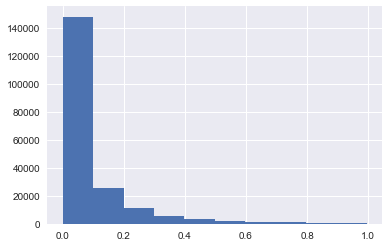

In [67]:
# Create the Submission
Y_pred = logist.predict_proba(test_inp_scaled2)[:,1]
submit = test[['ID_code']]
submit['target'] = Y_pred
print(submit.head())
submit.to_csv('log_reg_baseline.csv', index = False)
submit['target'].hist()

## 2.5 K-Folder Cross Validation
* When I need to find hyperparameters, I need to use validation set, or alternatively use cross validation.

In [53]:
# 5050 CV on penalty parameters(grid search)
logist = LogisticRegressionCV(solver = 'lbfgs', cv = 5)
%time logist.fit(X_train5050, Y_train5050)
print('Accuracy CV: ', logist.score(X_test5050, Y_test5050))

Wall time: 48.8 s
Accuracy CV:  0.7679781782112746
